In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
import pickle5 as pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import scipy.stats as stats

In [3]:
four_years_df = pd.read_pickle("cleaned_df.pkl")
four_years_df = four_years_df[four_years_df['MP']>250]
four_years_df = four_years_df.drop(['POS','Name','YEAR','Season','through_4_years','WITH SHOES','MP'],axis=1)
four_years_df = pd.get_dummies(four_years_df)


In [17]:
def resd_vs_fitted(preds,y_test):
    residuals = y_test - preds
    fitted = preds
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    plt.rcParams.update({'font.size': 16})
    plt.rcParams["figure.figsize"] = (8,7)
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(i,xy=(fittfed[i],residuals[i]))

    plt.show()

In [21]:
def select_pos_target_perform_regression(pos,target,four_years_df):
    four_years_df = four_years_df[four_years_df[pos]==1]
    X_train, X_test, y_train, y_test = train_test_split(four_years_df.drop(['BPM','Avg_BPM'],axis=1), four_years_df[target], test_size = .3, random_state = 3)

    assert X_test.shape[0] == y_test.shape[0], "wrong shapes for test set"
    assert X_train.shape[0] == y_train.shape[0], "wrong shapes for training set"
    
    lassocv = LassoCV(alphas=None, n_alphas=200,cv=10, max_iter=100000, normalize=True, random_state=1)
    lassocv.fit(X_train, y_train)
    lasso_cvalpha = Lasso(alpha=lassocv.alpha_, normalize=True)
    lasso_cvalpha.fit(X_train, y_train)
    lasso_pred = lasso_cvalpha.predict(X_test)
    
    lasso_rmse = mean_squared_error(y_test,lasso_pred,squared=False)
    lasso_mae = mean_absolute_error(y_test,lasso_pred)
    
    print('Best Lasso Model: Root Mean Square Error{} Mean absolute error {}'.format(lasso_rmse,lasso_mae),"\n")
        
    X_train_sig_coef = X_train.loc[:,lasso_cvalpha.coef_!=0]
    X_test_sig_coef = X_test.loc[:,lasso_cvalpha.coef_!=0]
    mod=sm.OLS(y_train,X_train_sig_coef)
    print(mod.fit().summary(),"\n")
    
    cv = LeaveOneOut()
    reg = LinearRegression()
    rmse_cv = cross_val_score(reg, X_train_sig_coef, y_train, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
    rmse=sqrt(mean(absolute(rmse_cv)))
    mae_cv = cross_val_score(reg, X_train_sig_coef, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
    mae = mean(absolute(mae_cv))
    reg = LinearRegression().fit(X_train_sig_coef,y_train)
    preds=reg.predict(X_test_sig_coef)
    
    
    print('Regression with Significant Digts:Root Mean Square Error{} Mean absolute error {}'.format(rmse,mae))
    
    if (rmse < lasso_rmse):
        return preds,y_test
    else:
        return lasso_pred,y_test

In [22]:
#point guard model: first year BPM 
predicted_value, true_value = select_pos_target_perform_regression('Pos_PG','BPM',four_years_df)



Best Lasso Model: Root Mean Square Error2.027425722087988 Mean absolute error 1.665223293665279 

                                 OLS Regression Results                                
Dep. Variable:                    BPM   R-squared (uncentered):                   0.332
Model:                            OLS   Adj. R-squared (uncentered):              0.324
Method:                 Least Squares   F-statistic:                              41.23
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                    7.98e-09
Time:                        12:36:48   Log-Likelihood:                         -199.59
No. Observations:                  84   AIC:                                      401.2
Df Residuals:                      83   BIC:                                      403.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef 

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Actuals')

Text(0.5, 1.0, 'PG First year BPM Model')

(-2.7336762348080184, -1.926491600552917, -7.3051766004415, 1.305176600441501)

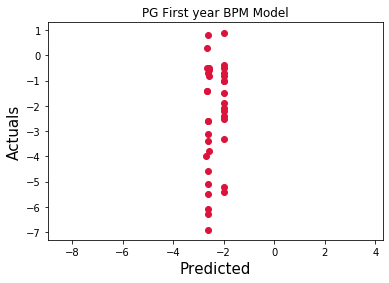

In [23]:
#Graph of point guard: first year BPM model
plt.scatter(predicted_value,true_value , c='crimson')

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('PG First year BPM Model')
plt.axis('equal')
plt.show()

In [27]:
#Shooting guard first year BPM model
predicted_value, true_value = select_pos_target_perform_regression('Pos_SG','BPM',four_years_df)



Best Lasso Model: Root Mean Square Error2.4245538421420036 Mean absolute error 1.9884279266301734 

                                 OLS Regression Results                                
Dep. Variable:                    BPM   R-squared (uncentered):                   0.410
Model:                            OLS   Adj. R-squared (uncentered):              0.403
Method:                 Least Squares   F-statistic:                              61.05
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                    1.11e-11
Time:                        12:38:04   Log-Likelihood:                         -211.93
No. Observations:                  89   AIC:                                      425.9
Df Residuals:                      88   BIC:                                      428.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coe

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Actuals')

Text(0.5, 1.0, 'SG First Year BPM Model')

(-3.233783370479989,
 -2.3989982915537946,
 -9.370176600441503,
 2.870176600441501)

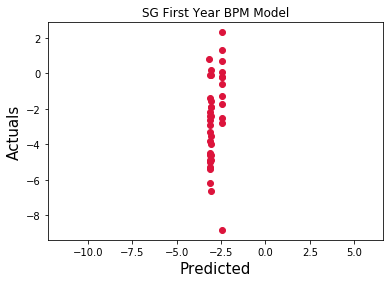

In [28]:
#Preds vs actual graphs
plt.scatter(predicted_value,true_value , c='crimson')

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('SG First Year BPM Model')
plt.axis('equal')
plt.show()

In [29]:
#Small forward first year BPM model
predicted_value, true_value = select_pos_target_perform_regression('Pos_SF','BPM',four_years_df)



Best Lasso Model: Root Mean Square Error2.4931096335820073 Mean absolute error 2.112470121624871 

                                 OLS Regression Results                                
Dep. Variable:                    BPM   R-squared (uncentered):                   0.705
Model:                            OLS   Adj. R-squared (uncentered):              0.651
Method:                 Least Squares   F-statistic:                              13.03
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                    3.47e-12
Time:                        12:38:26   Log-Likelihood:                         -134.70
No. Observations:                  71   AIC:                                      291.4
Df Residuals:                      60   BIC:                                      316.3
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Actuals')

Text(0.5, 1.0, 'SF First year BPM Model')

(-5.571103174851498, 0.27117664948216647, -6.5651766004415, 1.165176600441501)

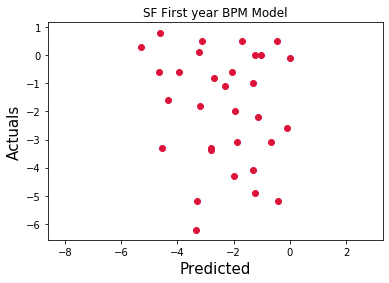

In [30]:
plt.scatter(predicted_value,true_value , c='crimson')

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('SF First year BPM Model')
plt.axis('equal')
plt.show()

In [31]:
predicted_value, true_value = select_pos_target_perform_regression('Pos_PF','BPM',four_years_df)


Best Lasso Model: Root Mean Square Error2.503497245396558 Mean absolute error 1.9962737127371268 

                                 OLS Regression Results                                
Dep. Variable:                    BPM   R-squared (uncentered):                   0.511
Model:                            OLS   Adj. R-squared (uncentered):              0.505
Method:                 Least Squares   F-statistic:                              84.80
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                    3.07e-14
Time:                        12:39:01   Log-Likelihood:                         -187.68
No. Observations:                  82   AIC:                                      377.4
Df Residuals:                      81   BIC:                                      379.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Actuals')

Text(0.5, 1.0, 'PF First year BPM Model')

(-2.805536402504039,
 -1.9542384769645955,
 -9.391843267108172,
 4.058509933774831)

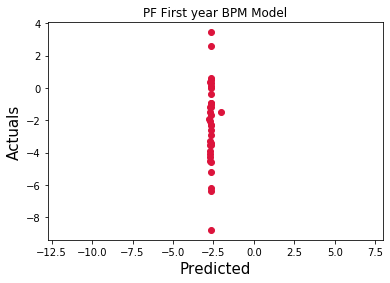

In [32]:
plt.scatter(predicted_value,true_value , c='crimson')

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('PF First year BPM Model')
plt.axis('equal')
plt.show()

In [33]:
predicted_value, true_value = select_pos_target_perform_regression('Pos_C','BPM',four_years_df)


Best Lasso Model: Root Mean Square Error1.6623607150274546 Mean absolute error 1.3964833759590796 

                                 OLS Regression Results                                
Dep. Variable:                    BPM   R-squared (uncentered):                   0.537
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              58.00
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                    6.56e-10
Time:                        12:39:27   Log-Likelihood:                         -116.16
No. Observations:                  51   AIC:                                      234.3
Df Residuals:                      50   BIC:                                      236.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coe

Text(0.5, 0, 'Predicted')

Text(0, 0.5, 'Actuals')

Text(0.5, 1.0, 'C First year BPM Model')

(-2.656425258275353, -2.636711996626608, -6.050176600441501, 1.350176600441501)

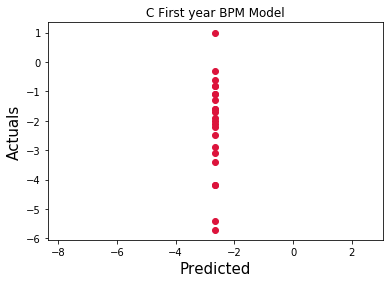

In [34]:
plt.scatter(predicted_value,true_value , c='crimson')

plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Actuals', fontsize=15)
plt.title('C First year BPM Model')
plt.axis('equal')
plt.show()